In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import logging

logging.basicConfig(level=logging.INFO)

from src.data_loader.data_loader import DataLoader

img_path = "data/train_images_small"
label_path = "data/venomous_status_metadata.csv"
meta_data_path = "data/train_images_metadata.csv"

data_loader = DataLoader(
    image_data_set_path=img_path,
    meta_data_path=meta_data_path,
    label_info_path=label_path
    )

INFO:numexpr.utils:NumExpr defaulting to 12 threads.
INFO:root:Initializing DataLoader...
INFO:root:Checking paths...
INFO:root:Loading metadata from data/train_images_metadata.csv...
INFO:root:Loading label info from data/venomous_status_metadata.csv...
INFO:root:Loading image data from data/train_images_small...
Loading metadata: 100%|██████████| 66454/66454 [00:19<00:00, 3337.64it/s]
INFO:root:Train: 53162, Val: 13291


In [2]:
from collections import Counter

all_samples = (data_loader.get_training_set() or []) + (data_loader.get_validation_set() or [])
cnt = Counter(s.original_class for s in all_samples)

logging.info("Unique class count: %d", len(cnt))  

INFO:root:Unique class count: 296


Unique classes: 296


,class,count
0,179,1839
1,180,1583
2,49,1489
3,284,1221
4,125,1065
...,...,...
195,183,140
196,182,140
197,225,139
198,192,139


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\marci\AppData\Local\Temp\ipykernel_25456\2474703645.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="class", data=plot_df, palette="viridis")
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


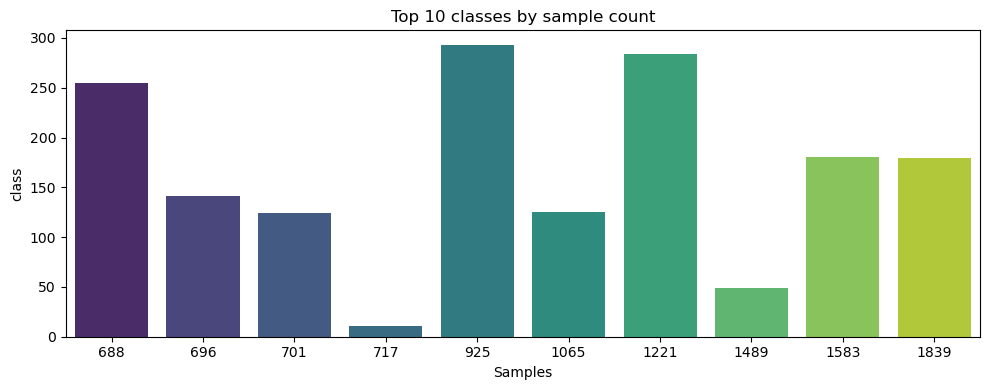

In [3]:
# Simple list and counts
from collections import Counter
import pandas as pd

all_samples = (data_loader.get_training_set() or []) + (data_loader.get_validation_set() or [])
cnt = Counter(s.original_class for s in all_samples)
df = pd.DataFrame(cnt.items(), columns=["class","count"]).sort_values("count", ascending=False).reset_index(drop=True)

print("Unique classes:", len(df))
display(df.head(200))  # mutasd az első 200 sorát (notebookban szép)
import matplotlib.pyplot as plt
import seaborn as sns

top_n = 10
plot_df = df.head(top_n).iloc[::-1]
plt.figure(figsize=(10, max(4, 0.25*len(plot_df))))
sns.barplot(x="count", y="class", data=plot_df, palette="viridis")
plt.title(f"Top {top_n} classes by sample count")
plt.xlabel("Samples")
plt.tight_layout()
plt.show()

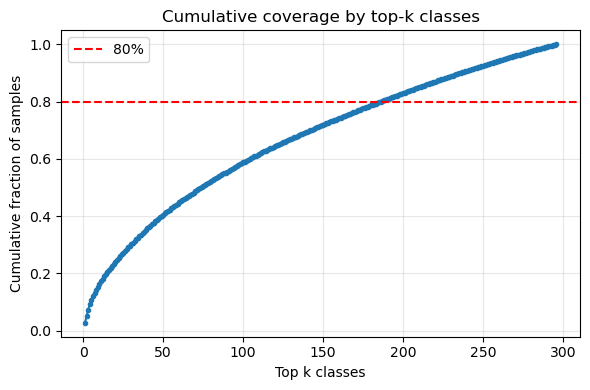

In [4]:
import numpy as np

counts = df["count"].values
sorted_counts = np.sort(counts)[::-1]
cum = np.cumsum(sorted_counts) / np.sum(sorted_counts)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cum)+1), cum, marker=".")
plt.axhline(0.8, color="red", linestyle="--", label="80%")
plt.xlabel("Top k classes")
plt.ylabel("Cumulative fraction of samples")
plt.title("Cumulative coverage by top-k classes")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

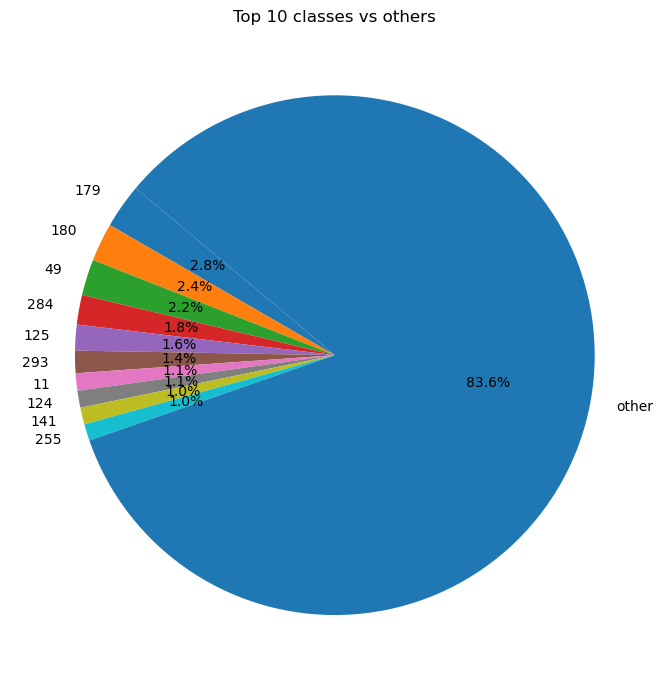

In [5]:
top_k = 10
top = df.head(top_k)
other_sum = df["count"].iloc[top_k:].sum()
labels = list(top["class"]) + ["other"]
sizes = list(top["count"]) + [other_sum]

plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title(f"Top {top_k} classes vs others")
plt.tight_layout()
plt.show()

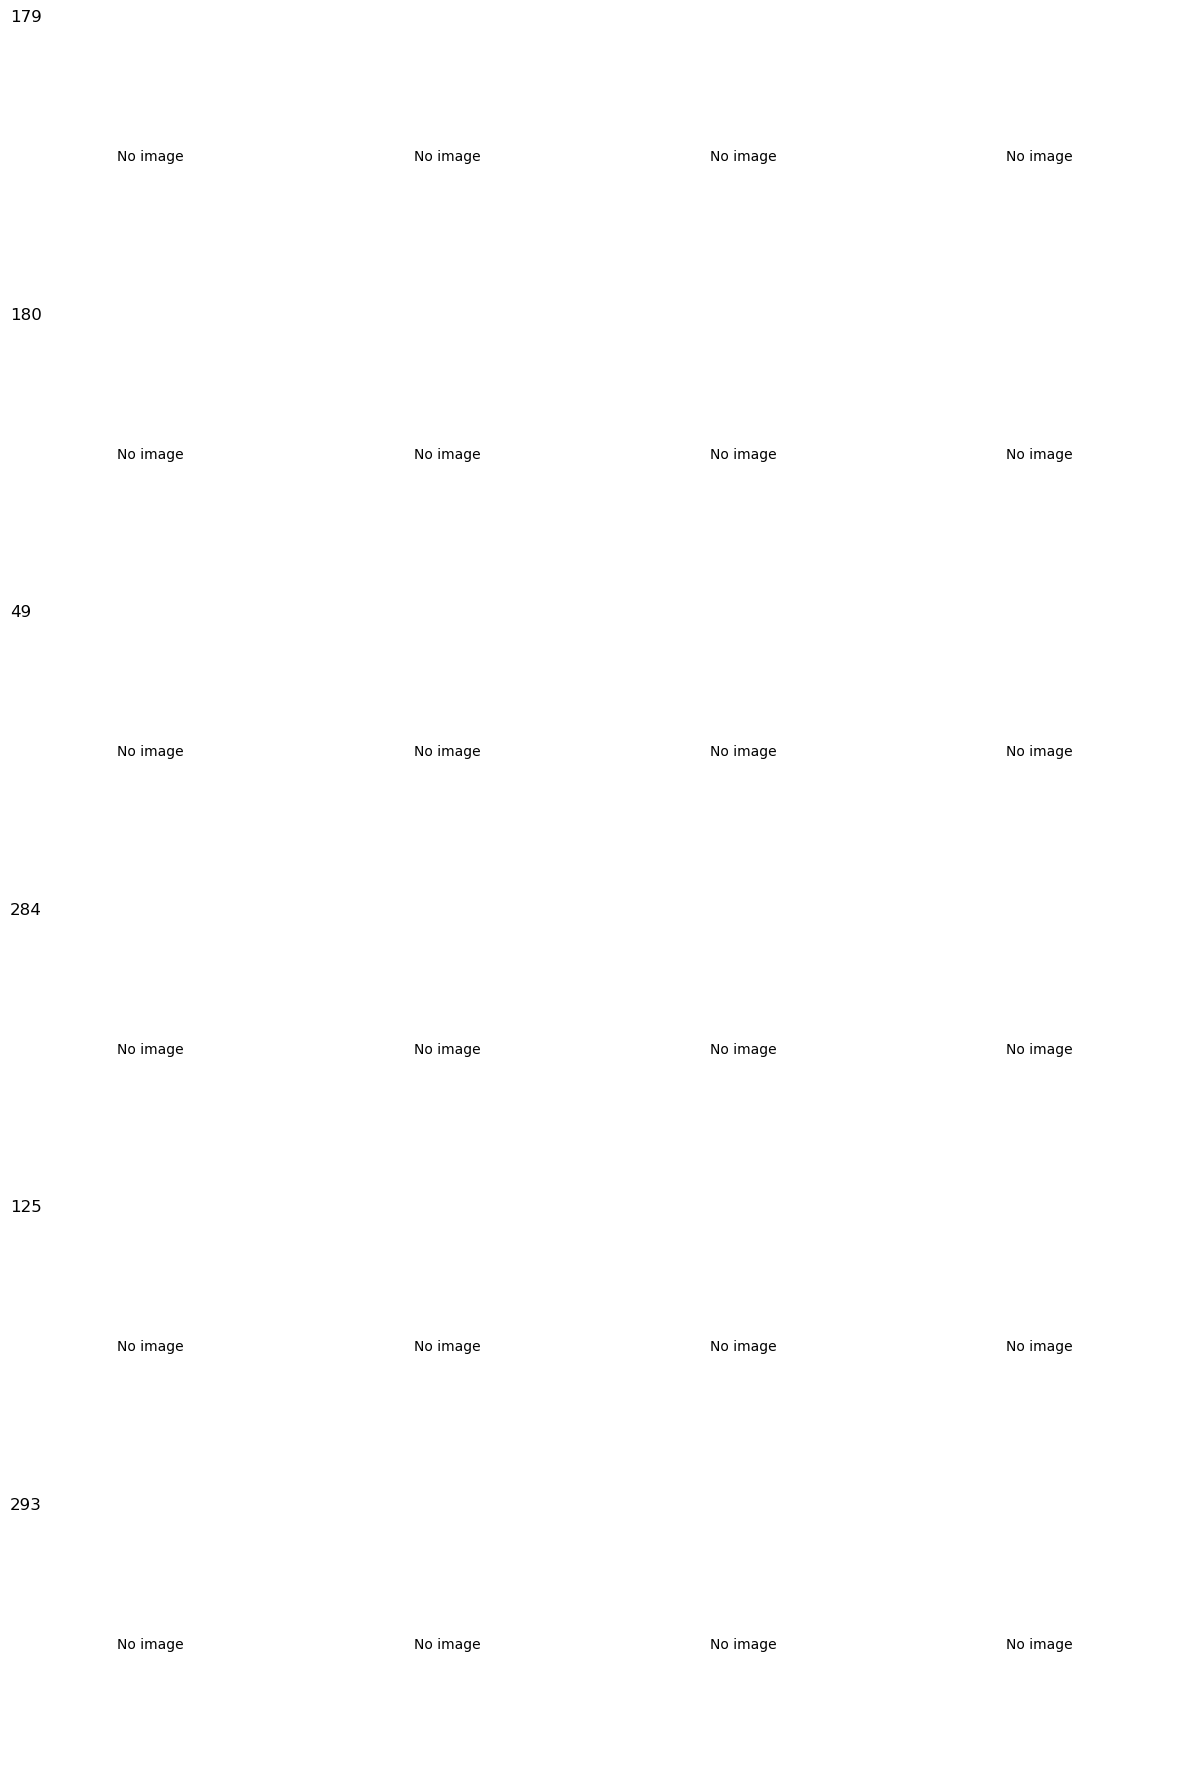

In [6]:
from PIL import Image
import math

# válassz néhány osztályt (pl. top 6)
selected = df["class"].head(6).tolist()
samples_by_class = {c: [] for c in selected}
for s in all_samples:
    if s.original_class in samples_by_class and len(samples_by_class[s.original_class]) < 4:
        samples_by_class[s.original_class].append(s)

fig_cols = 4
fig_rows = len(selected)
plt.figure(figsize=(fig_cols*3, fig_rows*3))
idx = 1
for i, cls in enumerate(selected):
    for j in range(fig_cols):
        plt.subplot(fig_rows, fig_cols, idx)
        idx += 1
        try:
            samp = samples_by_class[cls][j]
            samp.load_image()  # győződj meg róla, hogy az image betöltve
            # próbáljuk először a Sample.image-t használni, különben info['image_path']
            if getattr(samp, "image", None) is not None:
                img_t = samp.image  # feltételezzük: tensor C,H,W 0..1 vagy 0..255
                if isinstance(img_t, (list, tuple)):
                    img_t = img_t[0]
                if hasattr(img_t, "permute"):
                    im = img_t.detach().cpu()
                    if im.max() <= 1.01: im = (im*255).byte()
                    im = im.permute(1,2,0).numpy()
                else:
                    im = img_t
                plt.imshow(im)
            else:
                path = samp.info.get("image_path") or samp.info.get("path")
                img = Image.open(path).convert("RGB")
                plt.imshow(img)
            plt.axis("off")
        except Exception:
            plt.text(0.5, 0.5, "No image", ha="center")
            plt.axis("off")
    plt.subplot(fig_rows, fig_cols, (i+1)*fig_cols - (fig_cols-1))
    plt.title(cls, loc="left")
plt.tight_layout()
plt.show()

In [7]:
# ...existing code...
from collections import Counter
import pandas as pd

all_samples = (data_loader.get_training_set() or []) + (data_loader.get_validation_set() or [])
if not all_samples:
    print("Nincsenek betöltött sample-ek.")
else:
    cnt = Counter(s.original_class for s in all_samples)
    df = pd.DataFrame(cnt.items(), columns=["class","count"]).sort_values("count", ascending=False).reset_index(drop=True)

    min_count = int(df["count"].min())
    max_count = int(df["count"].max())
    min_classes = df[df["count"] == min_count]["class"].tolist()
    max_classes = df[df["count"] == max_count]["class"].tolist()

    print(f"Legkisebb példa-szám: {min_count} — osztály(ok): {min_classes}")
    print(f"Legnagyobb példa-szám: {max_count} — osztály(ok): {max_classes}")
# Extract the original_class values from all_samples and find the min and max
classes = [s.original_class for s in all_samples]
print(min(classes), max(classes))
print(len(pd.unique(classes)))
print(pd.unique(classes))

Legkisebb példa-szám: 96 — osztály(ok): [228]
Legnagyobb példa-szám: 1839 — osztály(ok): [179]
0 295
296
[125 140  50  83  69 294 225  52  24 271 121 292 261 260 177 250 167   2
  22 160  11 295 211 137 276 216  81 179  10  91 293  17 103  88 180 200
 157   1  76  48  45 282 136 222 257 191 285 107 192 127 130  35 193   4
  78  85  20  90  86  49 131 152 145 100  75  46 119  21 194 201 159   6
 132 173 183  33 189  23 263  15  87 230  94 213 133 146 105  98   8 289
 214 170 123 254  40 110 135 154 255 109 274 245 116 234  41  36  27 172
  39 124  60 242  16 259 212 185 196 161 134 232 206  96 239 220 155 198
 279 221  31 267 249 158 162  73 207  44  19 243 144  25 258   3 142   9
  92 184  80 195 149  26  64  54 101 147  28 223 284  65 219 229  18  79
 204 168   5 265 215  32 290 190 256 231 227  74  57 178  99  66  38 210
  56 288 203 264  51 138  84 209 268  89  77 262 205  13  37 244 273 233
 141 281 283 150  97 171 286 148 272 114 113 269 181  68  47 108 143  61
 106 175 166  72 24

C:\Users\marci\AppData\Local\Temp\ipykernel_25456\3907428767.py:22: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  print(len(pd.unique(classes)))
C:\Users\marci\AppData\Local\Temp\ipykernel_25456\3907428767.py:23: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  print(pd.unique(classes))
